In [4]:
import numpy as np
import scipy.integrate as integrate
from astropy.cosmology import WMAP9 as cosmo
from astropy import constants
from astropy import units as u
import scipy.interpolate
import math
import matplotlib.pyplot as plt


"""
_______________________________________________________________________________________________
"""

class GrowthFunction:
    def __init__(self, h=0.73, omega_m=0.27,omega_l=0.73):
        self.omega_m0 = omega_m
        self.omega_l0 = omega_l
        self.H_0=((h*100*u.km*u.s**-1*u.Mpc**-1).to(u.Gyr**-1)).value
        self.h=h
    
    """
    We need to create a growth factor function. Which depends on the cosmological model.
    1) find the evolution of the densities
    2) define the growth factor
    """

    def Time(self, z):
        return 2/3/(1+z)**(3/2)/self.H_0

    #hubble
    def E_of_z(self, redshift):
        """
        E(z) which describe the evolution of H(z)=E(z)*H0
        """
        Ez = (self.omega_l0 + (1.0 - self.omega_l0 
            - self.omega_m0) * (1.0+redshift)**2 
            + self.omega_m0 * (1.0+redshift)**3)**(1/2)

        return Ez

    #matter
    def omega_mz(self,redshift):
        return self.omega_m0 * (1.0+redshift)**3 / self.E_of_z(redshift)**2.0

    #Vacuum
    def omega_lz(self,redshift):
        return self.omega_l0 / (self.E_of_z(redshift))**2

    def g_of_z(self, redshift):
        """
        growth linear factor
        """

        gz = 2.5 * self.omega_mz(redshift) / (self.omega_mz(redshift)**(4/7) 
        - self.omega_lz(redshift) + ((1 + self.omega_mz(redshift)/2) 
        * (1 + self.omega_lz(redshift)/70)))

        return gz

    def D_of_z(self, redshift):
        """
        growth function
        """
        return self.g_of_z(redshift) / self.g_of_z(0.0) / (1.0+redshift)
    
    def Delta_c(self, redshift):
        return 1.686/self.D_of_z(redshift)


"""
_______________________________________________________________________________________________
"""

class Overdensities:
    
    def __init__(self,redshift=0,h7=1.05,h=0.73,omega_m=0.27,omega_l=0.73, ns=0.95,sigma8=0.8,Nbins_Sigma=50,logmass_lim=(4, 20)):

        if (h<=0.0):
            raise ValueError("Overdensities(): Negative Hubble constant illegal.\n")
        elif (h>2.0):
            raise ValueError("Overdensities(): Reduced Hubble constant h should be in units of 100 km/s/Mpc.\n")
        if (h7<=0.0):
            raise ValueError("Overdensities(): Negative Hubble constant illegal.\n")
        elif (h7>2.0):
            raise ValueError("Overdensities(): Reduced Hubble constant h7 should be in units of 70 km/s/Mpc.\n")
        if (redshift<=-1.0):
            raise ValueError("Overdensities(): Redshift < -1 is illegal.\n")
        elif (redshift>4000.0):
            raise ValueError("Overdensities(): Large redshift entered.  TF may be inaccurate.\n")

        Growth = GrowthFunction(omega_m = omega_m, omega_l = omega_l)

        self.omega_m0 = omega_m
        self.omega_l0 = omega_l
        self.h7=h7
        self.h=h
        self.Nbins_Sigma = Nbins_Sigma
        self.ns = ns
        self.redshift = redshift
        self.logmass_max = logmass_lim[1]
        self.logmass_min = logmass_lim[0]
        self.rho_0 = self.omega_m0 * 2.78e+11
        self.rho_0 =133363631951.67577
        #WMAP pivot scale
        self.kpivot = 2e-3

        self.D_of_z = Growth.D_of_z
        self.g_of_z = Growth.g_of_z

        #Normalization of the power spectrum
        self.N=1
        self.N=sigma8*sigma8 / (self.Sigma_of_R(self.TopHatFilter, 11.4))**2
        

        # output arrays
        # Smother radius [Mpc/h]
        self.R = np.empty(self.Nbins_Sigma,dtype='float64')
        # mass (M_sun/h)
        self.M = np.empty(self.Nbins_Sigma,dtype='float64')
        self.logM = np.empty(self.Nbins_Sigma,dtype='float64')
        #self.M = np.logspace(self.logmass_min, self.logmass_max, self.Nbins_Sigma)
        # sigma(M, z=0, where mass is in [M_sun/h])
        # array of sigma for three different filters
        self.Sigmas = np.empty(3, dtype=object)
        self.Sigmasz = np.empty(3, dtype=object)
        self.interpolates = np.empty(3, dtype=object)

        #we can initialize sigma(M) for the different filter to then interpolate
        self.Filters = (self.TopHatFilter, self.GaussianFilter, self.KSharpFilter)
        self.Ints = np.empty(3, dtype=object)

        for i in range(3):

            s, self.R = self.SigmaM_Array(self.Filters[i])
            self.Sigma = s
            self.Sigmas[i] = s
            sz = self.SigmaM_of_z()
            self.Sigmaz = sz
            self.Sigmasz[i] = sz
            interpolate = self.Interpolator()
            self.interpolates[i] = interpolate
            int = self.Sigma_of_M_and_z(self.M, interpolate)
            self.Ints[i] = int

    """
    Main function 
    Change filter if needed (self.GaussianFilter <-> self.KSharpFilter <-> self.TopHatFilter)
    _______________________________________________________________________________________________
    """
    def S(self, m):
        s = np.vectorize(self.S_prep)
        return s(m)

    def S_Z(self, m, z):
        sz = self.D_of_z(z)*self.S(m)
        return sz

    def S_Z_interpolate(self, m, z, interpolate):
        return self.D_of_z(z)*interpolate(np.log10(m))


    """
    _______________________________________________________________________________________________
    """

    
    def S_prep(self, m):
        gamma_f, c = (2*np.pi)**(2/3), 0.643
        R = c*(m/(gamma_f*self.rho_0))**(1/3)
        s = integrate.quad(self.integrant, 0, np.inf, args=(R, self.GaussianFilter), epsrel=1e-2, limit=100)[0]
        return (s/(2*np.pi**2))**(1/2)

    def TransferFunction(self, k):
        q=2.04/(self.omega_m0*self.h7**2)
        return np.log(1+2.34*q*k)/(2.34*q*k*(1+3.89*q*k+(16.1*q*k)**2+(5.46*q*k)**3+(6.71*q*k)**4)**(1/4))
    
    def PowerSpectrum(self, k):
        return self.N * self.TransferFunction(k)**2 * k * (k/self.kpivot)**(self.ns-1)
    
    """
    Now we define each filters. 
    Using the series expansion at low Rk make the integration more precised (for numerical integration).
    """

    def TopHatFilter(self, x):
        if x < 1e-2:
            return 1-x**2/10+x**4/280
            # return 1./3. - x**2/30. +x**4/840
        else:
            return 3/(x)**3*(np.sin(x)-x*np.cos(x))
        
    def GaussianFilter(self, x):
        if x < 1e-2:
            return 1-x**2/2+x**4/8
        else:
            return np.exp(-x**2/2)
        
    def KSharpFilter(self, x):
        if x <= 1:
            return 1
        else:
            return 0
    
    def integrant(self, k, R, Filter):
        return k**2*self.PowerSpectrum(k)*Filter(k*R)**2
    
    def Sigma_of_R(self, Filter, R):

        s2 = integrate.quad(self.integrant, 0, np.inf, args=(R, Filter), epsrel=1e-2, limit=100)[0]
        
        return (s2/(2*np.pi**2))**(1/2)

    def Sigma_of_M(self, Filter, M):

        if Filter == self.TopHatFilter:
            gamma_f, c = 4*np.pi/3, 1
        
        elif Filter == self.GaussianFilter:
            gamma_f, c = (2*np.pi)**(2/3), 0.643
        
        elif Filter == self.KSharpFilter:
            gamma_f, c = 6*np.pi**2, 1

        R = c*(M/(gamma_f*self.rho_0))**(1/3)

        s = integrate.quad(self.integrant, 0, np.inf, args=(R, Filter,), epsrel=1e-2, limit=200)[0]

        return (s/(2*np.pi**2))**(1/2), R
    
    def SigmaM_Array(self, Filter):
        
        s = np.empty(self.Nbins_Sigma, dtype='float64')
        R = np.empty(self.Nbins_Sigma, dtype='float64')

        dm = (self.logmass_max - self.logmass_min)/self.Nbins_Sigma

        for i in range(self.Nbins_Sigma):

            logM = self.logmass_min + i*dm

            M = 10.0**logM

            s[i], R[i]= self.Sigma_of_M(Filter, M)

            self.M[i] = M

            self.logM[i] = logM

        return s, R


    """The final function is ready to be set up"""

    def Interpolator(self):
        return scipy.interpolate.InterpolatedUnivariateSpline(self.logM, self.Sigma)

    def SigmaM_of_z(self):
        sz = self.D_of_z(self.redshift)*self.Sigma
        return sz

    def Sigma_of_M_and_z(self, M, interpolate):
        return self.D_of_z(self.redshift)*interpolate(np.log10(M))

"""
_______________________________________________________________________________________________
"""

class HaloMassFunction:

    def __init__(self, redshift, omega_m=0.27, omega_l=0.73, h=1.05, ns=0.95, sigma8=0.8, mass_function=None, Nbins=50, logmass_lim=(6, 20)):
        self.overden = Overdensities(redshift, omega_m=omega_m, omega_l=omega_l, h=h, ns=ns, sigma8=sigma8, Nbins_Sigma=Nbins, logmass_lim=logmass_lim)
        self.logM=self.overden.logM
        self.M = self.overden.M
        self.interpolates=self.overden.interpolates

        if mass_function == None:
            self.mass_function = self.press_schechter
        else:
            self.mass_function = mass_function.__get__(self)

        self.redshift = redshift
        Growth = GrowthFunction(omega_m=omega_m, omega_l=omega_l)

        self.Delta_c = Growth.Delta_c

        self.S = self.overden.S

        self.dndms=np.empty(3, dtype=object)

        for i in range(3):

            dndm=self.dndm_gen(self.M, self.interpolates[i])

            self.dndms[i] = dndm

    """
    Main function 
    _______________________________________________________________________________________________
    """
    def IMF(self, m, z):
        """Returns the halo mass function dn/dM in units of h^4 M_sun^-1 Mpc^-3
        Requires mass in units of M_sun /h """
        # Mean matter density at redshift z in units of h^2 Msolar/Mpc^3
        #This is rho_c in units of h^-1 M_sun (Mpc/h)^-3
        rho_0 = self.overden.rho_0 #self.overden.omega_matter_of_z(self.overden.redshift)

        dlogsigma, sigma = self.logderivative(m)
        mass_func = self.press_schechter_z(sigma, z)
        
        IMF = np.abs(dlogsigma)*mass_func/m*rho_0

        return IMF
    """
    _______________________________________________________________________________________________
    """

    def logderivative(self, M):
        sigma = self.S(M)
        sigma_plus = self.S(M**1.001)
        return (np.log(sigma_plus*sigma_plus)-np.log(sigma*sigma))/np.log(0.001*M), sigma

    def logderivative_filter(self, M, interpolate):
        sigma = interpolate(np.log10(M))
        sigma_plus = interpolate(1.1*np.log10(M))
        return (np.log(sigma_plus*sigma_plus)-np.log(sigma*sigma))/np.log(0.1*M), sigma
        
    
    def dndm_gen(self, M, interpolate):
        """Returns the halo mass function dn/dM in units of h^4 M_sun^-1 Mpc^-3
        Requires mass in units of M_sun /h """
        # Mean matter density at redshift z in units of h^2 Msolar/Mpc^3
        #This is rho_c in units of h^-1 M_sun (Mpc/h)^-3
        rho_0 = self.overden.rho_0 #self.overden.omega_matter_of_z(self.overden.redshift)

        dlogsigma, sigma = self.logderivative_filter(M, interpolate)
        mass_func = self.mass_function(sigma)
        
        dndM =  np.abs(dlogsigma)*mass_func/M*rho_0

        return dndM

    def press_schechter_z(self, sigma, z):
        """Press-Schechter (This form Lacey and Cole eq. 2.11 1993)"""
        nu = self.Delta_c(z) / sigma
        return np.sqrt(1/2*np.pi) * nu * np.exp(-0.5*nu*nu)

    def press_schechter(self, sigma):
        """Press-Schechter (This form Lacey and Cole eq. 2.11 1993)"""
        nu = self.Delta_c(self.redshift) / sigma
        return np.sqrt(1/2*np.pi) * nu * np.exp(-0.5*nu*nu)

    def sheth_tormen(self, sigma):
        """Sheth-Tormen 1999, eq. 6"""
        nu = self.Delta_c(self.redshift) / sigma
        A=0.3222
        a=0.707
        p=0.3
        return A*np.sqrt(2.0*a/math.pi)*(1.0+ np.power( 1.0/(nu*nu*a), p) )*  nu * np.exp(-0.5*a*nu*nu)

    def warren(self, sigma):
        """LANL fitting function - Warren et al. 2005, astro-ph/0506395, eqtn. 5 """
        A = 0.7234
        a = 1.625
        b = 0.2538
        c = 1.1982
        return A*( np.power(sigma, -1.0*a) + b)*np.exp(-1.0*c / sigma / sigma )

    def watson_FOF(self, sigma):
        """Watson 2012, eq. 12"""
        A = 0.282
        a = 2.163
        b = 1.406
        c = 1.210
        return A*( np.power(b / sigma, 1.0*a) + 1)*np.exp(-1.0*c / sigma / sigma )

"""
_______________________________________________________________________________________________
"""


class MergerRate:
    def __init__(self, redshift, redshift_lim = (0, 12), M_1=5e13, omega_m=0.27, omega_l=0.73, h=0.73, ns=0.95, sigma8=0.8, Nbins=50, logmass_lim=(6, 20)):
        self.omega_m0 = omega_m
        self.omega_l0 = omega_l
        self.logmass_lim = logmass_lim
        self.sigma8 = sigma8
        self.h=h
        self.Nbins = Nbins
        self.ns = ns
        self.redshift = redshift
        self.logmass_max = logmass_lim[1]
        self.logmass_min = logmass_lim[0]
        self.rho_0 = self.omega_m0 * 2.78e+11
        self.M_1=M_1
        self.redshift_max_lim = redshift_lim[1]
        self.redshift_min_lim = redshift_lim[0]
        #self.rho_0 =133363631951.67577


        self.HMF = HaloMassFunction(redshift, omega_m=omega_m, omega_l=omega_l, h=h, ns=ns, sigma8=sigma8, Nbins=Nbins, logmass_lim=logmass_lim)
    
        Growth = GrowthFunction(omega_m=omega_m, omega_l=omega_l)

        self.Delta_c = Growth.Delta_c
        self.Time = Growth.Time

        overden = Overdensities(0, omega_m=self.omega_m0, omega_l=self.omega_l0, h=self.h, ns=self.ns, sigma8=self.sigma8, 
        Nbins_Sigma = self.Nbins, logmass_lim=self.logmass_lim)

        self.S=overden.S



    """Create a merger rate at a fixed final mass in terms of the redshift"""

    def MergerRate_M_Z(self, M2, M1, Z):

        der, sigma2 = self.logderivative(M2)
        sigma1 = self.S(M1)

        MR = M2/(2*np.pi)**(1/2)*np.abs(2/3*self.Delta_c(Z)/self.Time(Z)*der)*((sigma1/sigma2)**2/(sigma1**2-sigma2**2))**(3/2)*np.exp(-0.5*self.Delta_c(Z)**2*(1/sigma2**2-1/sigma1**2))

        return MR
    
    def MergerRate_M_Z2(self, M2, M1, Z):

        interpolate = self.overden.interpolates[1]

        der, sigma2 = self.derivative2(M2, interpolate)
        sigma1 = interpolate(np.log10(M1))

        MR = M2/(2*np.pi)**(1/2)*np.abs(2/3*self.Delta_c(Z)/self.Time(Z)*der)*((sigma1/sigma2)**2/(sigma1**2-sigma2**2))**(3/2)*np.exp(-0.5*self.Delta_c(Z)**2*(1/sigma2**2-1/sigma1**2))

        return MR
    
    def MR_Sommerville(self, M1, z1, M0, z0):
        f=1/np.sqrt(2*np.pi)*(self.Delta_c(z1)-self.Delta_c(z0))/(self.S(M1)-self.S(M0))**(3/2)*np.exp((self.Delta_c(z1)-self.Delta_c(z0))**2/(2*self.S(M1)-2*self.S(M0)))
        return M0/M1*f*np.abs(self.logderivative(M0)[0])


    """Create a merger rate at a fixed redshift in terms of the mass"""
    def MergerRate_of_M2(self):
        
        overden = Overdensities(self.redshift, omega_m=self.omega_m0, omega_l=self.omega_l0, h=self.h, ns=self.ns, sigma8=self.sigma8, 
        Nbins_Sigma = self.Nbins, logmass_lim=self.logmass_lim)

        interpolate = overden.interpolates[1]

        DeltaM = np.empty(self.Nbins, dtype=object)
        LogdeltaM = np.empty(self.Nbins, dtype=object)

        MR = np.empty(self.Nbins, dtype=object)

        logDMmin = -2
        logDMmax = 2
        sigma1 = interpolate(np.log10(self.M_1))
        dlogm = (logDMmax-logDMmin)/self.Nbins

        for i in range(self.Nbins):

            thislogDM = logDMmin + i*dlogm
            thisDM = 10**(thislogDM)*self.M_1
            thisM2 = thisDM + self.M_1

            der , sigma2 = self.logderivative2(thisM2, interpolate)

            MR[i] = 3/1e-3*(2/np.pi)**(1/2)/self.Time(self.redshift)*2/3*thisDM/thisM2*np.abs(der)*self.Delta_c(self.redshift)/sigma2/(1-(sigma2/sigma1)**2)**(3/2)*np.exp(-0.5*self.Delta_c(self.redshift)**2*(1/sigma2**2-1/sigma1**2))
            DeltaM[i] = thisDM
            LogdeltaM[i] = thislogDM

        return MR, DeltaM, LogdeltaM

    def logderivative(self, M):
        sigma = self.S(M)
        sigma_plus = self.S(1.00000000001*M)
        return (sigma_plus*sigma_plus-sigma*sigma)/(0.00000000001*M), sigma

            
    def logderivative2(self, M, interpolate):
        sigma = interpolate(np.log10(M))
        sigma_plus = interpolate(np.log10(1.1*M))
        return (np.log(sigma_plus)-np.log(sigma))/np.log(0.1*M), sigma
    
    def derivative2(self, M, interpolate):
        sigma = interpolate(np.log10(M))
        sigma_plus = interpolate(np.log10(1.00000000001*M))
        return (sigma_plus*sigma_plus-sigma*sigma)/(0.00000000001*M), sigma
    
    def Delta_c_derivative(self, z):
        DT = self.Delta_c(z)
        DTplus = self.Delta_c(1.0001*z)
        return (DTplus-DT)/0.0001*z

In [5]:
np.log10(5)

0.6989700043360189

In [6]:
MR =MergerRate(0)
mp = np.logspace(0, 2, 100)
P = MR.MR_Sommerville(1e14/mp, 0.2, 1e14, 0)

<ipython-input-4-9953278ae2a5>:227: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  s = integrate.quad(self.integrant, 0, np.inf, args=(R, Filter,), epsrel=1e-2, limit=200)[0]
<ipython-input-4-9953278ae2a5>:438: RuntimeWarning: divide by zero encountered in true_divide
  f=1/np.sqrt(2*np.pi)*(self.Delta_c(z1)-self.Delta_c(z0))/(self.S(M1)-self.S(M0))**(3/2)*np.exp((self.Delta_c(z1)-self.Delta_c(z0))**2/(2*self.S(M1)-2*self.S(M0)))


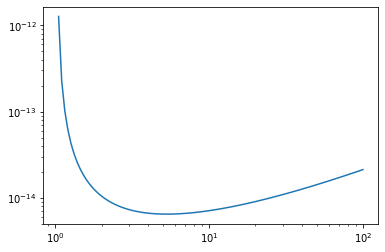

In [7]:
plt.plot(mp, P)
plt.yscale('log')
plt.xscale('log')

In [8]:
from scipy.stats import norm
class MergerTree:

    def __init__(self, omega_m=0.27, omega_l=0.73, h=0.73, ns=0.95, sigma8=0.8):
        self.omega_m0 = omega_m
        self.omega_l0 = omega_l
        self.sigma8 = sigma8
        self.h = h
        self.ns = ns
        self.rho_0 = self.omega_m0 * 2.78e+11

        self.overdensity = Overdensities(0, omega_l=omega_l, omega_m=omega_m, h=h, sigma8=sigma8, ns=ns)
        self.MergerRate = MergerRate(0, omega_l=omega_l, omega_m=omega_m, ns=ns, h=h, sigma8=sigma8)
        self.Growth = GrowthFunction(omega_m=omega_m, omega_l=omega_l, h=h)

        self.sigma = self.overdensity.S
        self.Delta_c = self.Growth.Delta_c

        m = np.logspace(0, 16, 1000)
        sig = self.sigma(m)
        int = scipy.interpolate.InterpolatedUnivariateSpline(m, sig)
        self.sigma_int = np.vectorize(int)

    def MT_Routine(self, M0, z0, z_m):

        Ms = []
        DM=M0
        # Ml = 10**(np.log10(M0)-4)
        
        Ml=10**4
        
        i=0

        while DM>Ml:
            
            # Ml = 10**(np.log10(DM)-4)
            # sigma_c = self.Delta_c(z_m)
            # M_c = self.M_finder(sigma_c**(-3/2)*DM, sigma_c)

            # domegaC = 0.8+0.3*np.log10(DM/Ml)*self.OmegaStep(DM, DM-M_c)

            domegaC = self.Delta_c(z_m)-self.Delta_c(z0)

            M = self.M_picker(DM, domegaC)

            DM=DM-M

            if M>Ml:
                Ms.append(M)
                i+=1
                
            if i==2:
                break
            
        # M_acc = M_and_z[0]-np.sum(np.array(Ms))

        return Ms


    def M_picker(self, M0, domega):

        i=0

        while i<1:
            
            # domega = np.random.uniform(0, domega)

            x_output = np.abs(np.random.normal(0,1))

            dS = (domega/(2*x_output))**2
            
            if dS<(domega/2)**2:
                i+=1

        S = self.sigma(M0)**2+dS

        return self.M_finder(M0, S)
    
    # def Delta_Z(self, num_points):

    #     z = np.linspace(10, 30, 100)
    #     y = self.Delta_c(z)
    #     z_int = scipy.interpolate.interp1d(y, z)
    #     y_interp = np.linspace(y[0], y[-1], num_points)

    #     return z_int(y_interp)


    def M_finder(self, M0, S):
        return float(scipy.optimize.fsolve(self.S_for_M, M0, args=S))
        
    def S_for_M(self, M, S):
        return self.sigma_int(M)**2-S
    
    def derivative(self, M):
        sigma = self.sigma(M)
        sigma_plus = self.sigma(1.000000001*M)
        return (sigma_plus*sigma_plus-sigma*sigma)/(0.000000001*M)
    
    def z_finder(self, z_0, domega):
        Df = self.Delta_c(z_0)+domega
        return float(scipy.optimize.fsolve(self.Delta_c_for_z, z_0, args=Df))

    def Delta_c_for_z(self, z, D_z_f):
        return self.Delta_c(z)-D_z_f

    def OmegaStep(self, M0, dMc):
        return np.sqrt(np.abs(self.derivative(M0))*dMc)

In [9]:
z=np.linspace(0, 30, 100)
MT = MergerTree()
sigma_star = MT.Delta_c(z)/3
M = np.zeros(len(z))
for i in range(len(M)):
    M[i] = np.log10(MT.M_finder(10**(4), sigma_star[i]))


<ipython-input-4-9953278ae2a5>:227: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  s = integrate.quad(self.integrant, 0, np.inf, args=(R, Filter,), epsrel=1e-2, limit=200)[0]


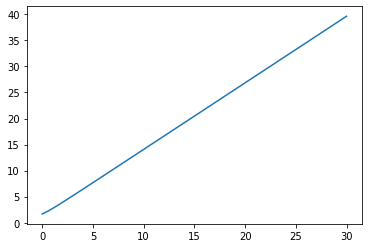

In [10]:
z=np.linspace(0, 30,100)
plt.plot(z, MT.Delta_c(z))

In [11]:
MT.sigma(10**4)

array(10.36491526)

(0.0, 30.0)

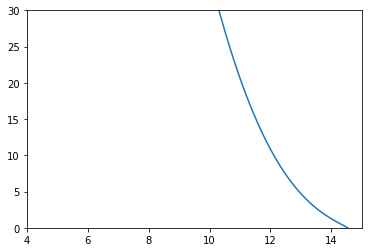

In [12]:
plt.plot(M, z)
plt.xlim(4, 15)
plt.ylim(0, 30)

In [13]:
import time 
t0 = time.time()
MT = MergerTree()
for i in range(20):
    Ms = MT.MT_Routine(1e12, 10, 11.5)
    # print(np.sum(Ms)+M_acc)
    print(Ms)
    print(time.time()-t0)

<ipython-input-4-9953278ae2a5>:227: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  s = integrate.quad(self.integrant, 0, np.inf, args=(R, Filter,), epsrel=1e-2, limit=200)[0]


[666799836234.661, 235249881081.93265]
1.4231438636779785
[608808104165.5233, 361129717029.6036]
1.4261927604675293
[598346913282.7728, 359195922003.81854]
1.429947853088379
[841820637390.0193, 124674488787.36302]
1.4347891807556152
[789500581154.2634, 196116555044.2589]
1.4402170181274414
[840407225672.5293, 140760907045.7033]
1.4432709217071533
[942668617799.9976, 52578583075.22177]
1.448157787322998
[773022772228.0583, 157183682318.76395]
1.451319932937622
[866580105602.8552, 112183298165.9176]
1.4880318641662598
[853431782093.8643, 102059162607.3577]
1.507131814956665
[892327538125.0645, 88020785161.74385]
1.5109128952026367
[674939465530.6313, 250650052797.56705]
1.5144259929656982
[824817343264.7347, 151582911182.15744]
1.5208728313446045
[799668704949.1918, 151360939763.30084]
1.5282008647918701
[888081390072.6669, 107178117310.31783]
1.5336418151855469
[816525273361.0884, 129120996136.24368]
1.5385448932647705
[593985901126.6125, 255317422777.79758]
1.5416319370269775
[62885147

In [14]:
from itertools import chain

mfinder = np.vectorize(MT.M_finder)

In [15]:
n_halos=1000

Halos =[4.14192626e+04, 1.30983541e+04, 2.34212951e+06, 2.70304337e+05,
       4.25275348e+06, 1.55697850e+05, 5.95238475e+05, 8.64868135e+05,
       2.40002323e+09, 8.58108271e+04, 6.30215097e+06, 5.16754663e+04,
       3.65909688e+07, 2.56068476e+04, 2.73310120e+05, 9.01183149e+04,
       5.27713252e+05, 1.71776023e+06, 1.35785260e+07, 6.64251958e+04,
       5.26413919e+05, 5.00285807e+04, 7.14737891e+07, 3.11841808e+04,
       4.35671325e+06, 3.27777166e+05, 1.69701085e+04, 5.59917758e+05,
       2.35281701e+04, 4.08792949e+08, 5.85657292e+05, 1.76794568e+06,
       4.88613040e+06, 6.15386295e+08, 1.17603503e+05, 1.91157216e+04,
       7.16393453e+06, 8.43446419e+04, 2.48967080e+06, 1.18024885e+04]

In [16]:
HIMF=HaloMassFunction(0)
m = np.logspace(4, 10, 100)

<ipython-input-4-9953278ae2a5>:227: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  s = integrate.quad(self.integrant, 0, np.inf, args=(R, Filter,), epsrel=1e-2, limit=200)[0]


In [17]:
def halo_PDF_norm(z):
    return integrate.quad(HIMF.IMF, 10**3, 10**10, args=(z), epsrel=1e-4, limit=1000)[0]

In [18]:
Himf_10 = HIMF.IMF(m, 10)/halo_PDF_norm(10)

KeyboardInterrupt: 

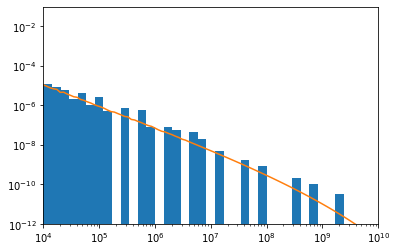

In [ ]:
plt.hist(Halos, density=True, bins=10**np.linspace(4, 10, 40))
M=np.logspace(4, 10, 100)
plt.plot(M, Himf_10)
plt.xlim(10**4, 10**10)
plt.ylim(1e-12,1e-1)
plt.xscale('log')
plt.yscale('log')

In [ ]:
MT = MergerTree()
z=10
Ms= Halos
print(z)

<ipython-input-33-9953278ae2a5>:227: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  s = integrate.quad(self.integrant, 0, np.inf, args=(R, Filter,), epsrel=1e-2, limit=200)[0]


10


In [ ]:
t0 = time.time()
while z<30:
    
    Mss=[]
    for ii in range(len(Ms)):
        routine = MT.MT_Routine(Ms[ii], z, z+0.5)
        Mss.append(routine)
        
    z=z+0.5
    Mss = list(chain.from_iterable(Mss))
    Ms = Mss
    print(z)
    print(time.time()-t0, len(Ms))

10.5
0.15018081665039062 54
11.0
0.29817795753479004 70
11.5
0.48372983932495117 88
12.0
0.8337159156799316 109
12.5
1.3138868808746338 135
13.0
1.8946187496185303 162
13.5
2.629276752471924 191
14.0
3.3422598838806152 222
14.5
3.99996280670166 256
15.0
4.64525580406189 294
15.5
5.3776397705078125 332
16.0
6.198820114135742 372
16.5
7.117860794067383 416
17.0
8.17835283279419 463
17.5
9.616317987442017 513
18.0
11.460824012756348 566
18.5
13.026726961135864 623
19.0
14.531452894210815 681
19.5
16.18581986427307 738
20.0
18.094437837600708 801
20.5
20.050514936447144 869
21.0
22.515828847885132 939
21.5
24.765934944152832 1005
22.0
27.179109811782837 1075
22.5
29.76254892349243 1149
23.0
32.51687812805176 1227
23.5
35.440794706344604 1309
24.0
38.56419491767883 1392
24.5
42.00455594062805 1480
25.0
45.50125002861023 1565
25.5
49.25467109680176 1658
26.0
55.136624813079834 1750
26.5
59.406564712524414 1843
27.0
63.78569483757019 1946
27.5
69.10612893104553 2049
28.0
74.15097904205322 215

In [ ]:
len(Ms)

2570

In [ ]:
HIMF=HaloMassFunction(0)
m = np.logspace(4, 10, 100)
Himf = HIMF.IMF(m, 30)/np.abs(halo_PDF_norm(30))
Himf

<ipython-input-33-9953278ae2a5>:227: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  s = integrate.quad(self.integrant, 0, np.inf, args=(R, Filter,), epsrel=1e-2, limit=200)[0]
<ipython-input-14-88f75843171e>:2: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return integrate.quad(HIMF.IMF, 10**3, 10**10, args=(z), epsrel=1e-4, limit=1000)[0]


array([1.48058058e-05, 1.12479876e-05, 8.48513695e-06, 6.47949075e-06,
       5.11921719e-06, 3.79926100e-06, 3.05086867e-06, 2.24640807e-06,
       1.70116484e-06, 1.28478817e-06, 8.60174734e-07, 7.03469381e-07,
       5.95965900e-07, 4.28689594e-07, 3.22573520e-07, 2.42199799e-07,
       1.83805553e-07, 1.35296069e-07, 1.01603763e-07, 7.90074744e-08,
       5.71554722e-08, 4.47130120e-08, 3.21330703e-08, 2.36302391e-08,
       1.72838899e-08, 1.07745913e-08, 8.85012756e-09, 7.14609429e-09,
       4.98082077e-09, 3.59540306e-09, 2.19300295e-09, 1.87086992e-09,
       1.33642405e-09, 9.37718346e-10, 6.95110650e-10, 4.75698810e-10,
       3.51639466e-10, 2.39315675e-10, 1.65957876e-10, 1.14146689e-10,
       7.88363835e-11, 5.57646339e-11, 3.83721471e-11, 2.49084531e-11,
       1.66841853e-11, 1.10899004e-11, 7.39638505e-12, 4.84303004e-12,
       3.19726570e-12, 2.07882236e-12, 1.34086494e-12, 8.57760080e-13,
       5.43815545e-13, 3.42395157e-13, 2.13605891e-13, 1.32029387e-13,
      

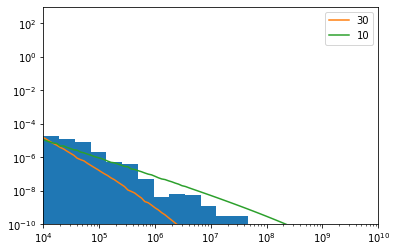

In [ ]:
plt.hist(Ms, bins=10**np.linspace(4,15,40), log=True, density=True)
plt.plot(m, Himf, label='30')
plt.plot(m, Himf_10, label='10')
plt.ylim(1e-10,1e3)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e4, 1e10)
plt.legend()

In [ ]:
len(Ms)

1826

In [42]:
from scipy.stats import norm
class MergerTree_2:

    def __init__(self, omega_m=0.27, omega_l=0.73, h=0.73, ns=0.95, sigma8=0.8):
        self.omega_m0 = omega_m
        self.omega_l0 = omega_l
        self.sigma8 = sigma8
        self.h = h
        self.ns = ns
        self.rho_0 = self.omega_m0 * 2.78e+11

        self.overdensity = Overdensities(0, omega_l=omega_l, omega_m=omega_m, h=h, sigma8=sigma8, ns=ns)
        self.MergerRate = MergerRate(0, omega_l=omega_l, omega_m=omega_m, ns=ns, h=h, sigma8=sigma8)
        self.Growth = GrowthFunction(omega_m=omega_m, omega_l=omega_l, h=h)

        self.sigma = self.overdensity.S
        self.Delta_c = self.Growth.Delta_c

        m = np.logspace(0, 16, 1000)
        sig = self.sigma(m)
        int = scipy.interpolate.InterpolatedUnivariateSpline(m, sig)
        self.sigma_int = np.vectorize(int)

    def MT_routine(self, M0, z0):

        dz = 1

        M_res = 1e4

        P = self.P(M_res, z0, M0, dz)
        print(P)

        while P>0.01:
            dz = dz-0.01
            P = self.P(M_res, z0, M0, dz)
            print('routine', z)

        R = np.random.uniform(0,1)
        F = self.F(M_res, z0, M0, dz)
        if R>P:
            M0 = M0*(1-F)
            M1=0

        else:
            M1 = self.M_gen(M_res, z0, M0, dz)
            M0 = M0*(1-F) - M1
        
        z = z0+dz

        return M0, M1, z


    def M_gen(self, M_res, z1, M2, dz):

        fmax = self.dNdM1(0.9*M_res/2, z1, M2, dz)

        ii=0

        while ii<1:

            x = np.random.uniform( M_res, M2/2, 100)
            y = np.random.uniform(0, fmax, 100)

            x_accepted = x[(y <= self.dNdM1(x, z1, M2, dz))]
            ii+=len(x_accepted)

            print('gen')
        
        return x_accepted[:1][0]


    def dfdz_1(self, M1, z1, M2, dz):

        s1 = self.sigma(M1)
        s2 = self.sigma(M2)

        d_delta = self.Delta_c(z1)-self.Delta_c(z1+dz)

        f = np.sqrt(2/np.pi) * s1**2/(s1**2-s2**2)**(2/3) * d_delta/dz * self.derivative(M1)

        return f
    
    def dNdM1(self, M1, z1, M2, dz):

        dNdM = 1/M1 * self.dfdz_1(M1, z1, M2, dz) * M2 / M1 * dz

        return dNdM
    
    def P(self, M_res, z1, M2, dz):
        
        print(z1)
        P=integrate.quad(self.dNdM1, M_res, M2/2, args = (z1, M2, dz), limit=100)[0]

        return P

    def F(self, M_res, z1, M2, dz):

        F=integrate.quad(lambda m : self.dNdM1(m, z1, M2, dz)*m/M2, 0, M_res, limit=100)[0]

        return F

    def M_finder(self, M0, S):
        return float(scipy.optimize.fsolve(self.S_for_M, M0, args=S))
        
    def S_for_M(self, M, S):
        return self.sigma_int(M)**2-S
    
    def derivative(self, M):
        sigma = np.log(self.sigma(M))
        sigma_plus = 1.000000001*np.log(self.sigma(M))
        return (sigma_plus*sigma_plus-sigma*sigma)/(0.000000001*np.log(M))
    
    def z_finder(self, z_0, domega):
        Df = self.Delta_c(z_0)+domega
        return float(scipy.optimize.fsolve(self.Delta_c_for_z, z_0, args=Df))

    def Delta_c_for_z(self, z, D_z_f):
        return self.Delta_c(z)-D_z_f

    def OmegaStep(self, M0, dMc):
        return np.sqrt(np.abs(self.derivative(M0))*dMc)

In [43]:
MT2 = MergerTree_2()

for i in range(10):
    print(MT2.MT_routine(1e6, 20))

<ipython-input-4-9953278ae2a5>:227: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  s = integrate.quad(self.integrant, 0, np.inf, args=(R, Filter,), epsrel=1e-2, limit=200)[0]


20


<ipython-input-42-ea895bb29a44>:92: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  P=integrate.quad(self.dNdM1, M_res, M2/2, args = (z1, M2, dz), limit=100)[0]


-1009.0285952551983


<ipython-input-42-ea895bb29a44>:98: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  F=integrate.quad(lambda m : self.dNdM1(m, z1, M2, dz)*m/M2, 0, M_res, limit=100)[0]


(564736468.0543985, 0, 21)
20
-1009.0285952551983
(564736468.0543985, 0, 21)
20
-1009.0285952551983
(564736468.0543985, 0, 21)
20
-1009.0285952551983
(564736468.0543985, 0, 21)
20
-1009.0285952551983
(564736468.0543985, 0, 21)
20
-1009.0285952551983
(564736468.0543985, 0, 21)
20
-1009.0285952551983
(564736468.0543985, 0, 21)
20
-1009.0285952551983
(564736468.0543985, 0, 21)
20
-1009.0285952551983
(564736468.0543985, 0, 21)
20
-1009.0285952551983
(564736468.0543985, 0, 21)


In [48]:
import ytree
a = ytree.load("ahf_halos/snap_N64L16_000.parameter", hubble_constant=0.7)
p = ytree.TreePlot(a[0], dot_kwargs={'rankdir': 'LR', 'size': '"12,4"'})
p.save('tree.png')

OSError: File does not exist: ahf_halos/snap_N64L16_000.parameter.